In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from sklearn import preprocessing

In [20]:
yt_data_us = r"C:\Users\mjeas\Desktop\CoderGirl\YT_Data\USvideos.csv"
yt_df = pd.read_csv(yt_data_us)

In [4]:
#This is what I am starting with
yt_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [5]:
#yt_df.info()

In [6]:
#Look for Null/missing Values
missing_values_count = yt_df.isnull().sum()
missing_values_count

#Looks like descriptions is the only column that is missing data. This is fine since I will not be using this category for my analysis anyways.

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [7]:
#Checking for duplicate values where there shouldn't be any.There should be no duplicates in video_id
#I discovered that some of the vales will be duplicates. A video can be a top streamer for more than one day running thus, there will be duplicates in the data.

#yt_df.nunique(axis=0)

In [8]:
#yt_df.shape

In [9]:
yt_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,category_id,views,likes,dislikes,comment_count
count,40949.000000,40949.000000,40949.000000,40949.000000,40949.000000
mean,19.972429,2360784.638257,74266.702435,3711.400889,8446.803683
std,7.568327,7394113.759704,228885.338209,29029.705945,37430.486994
min,1.000000,549.000000,0.000000,0.000000,0.000000
25%,17.000000,242329.000000,5424.000000,202.000000,614.000000
50%,24.000000,681861.000000,18091.000000,631.000000,1856.000000
75%,25.000000,1823157.000000,55417.000000,1938.000000,5755.000000
max,43.000000,225211923.000000,5613827.000000,1674420.000000,1361580.000000


In [36]:
#Dropping the categories that I am not interested in
yt_clean = yt_df.drop(['thumbnail_link','description','tags'], axis=1)

#Pullout out all records that have deleted the posted trending video
yt_clean = yt_clean.drop(yt_clean[yt_clean.video_error_or_removed == True].index)

#Changing these categories to standardized date types
yt_clean['publish_time'] = pd.to_datetime(yt_clean.publish_time).dt.tz_localize(None)
yt_clean['trending_date'] = pd.to_datetime(yt_clean['trending_date'],format='%y.%d.%m')

#Adding a column to examine like to dislike ratio
yt_clean['like_dislike'] = yt_clean['likes']/yt_clean['likes'] + yt_clean['dislikes']*100

#Chaning the type for category_id so that I can add in the actual category names from another file
yt_clean['category_id']= yt_clean['category_id'].astype(str)

#Adding in category names
yt_clean['category_id'] = yt_clean['category_id'].map({'1':'Film & Animation', '2':'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17':'Sports', '18':'Short Movies', '19':'Travel & Events',
              '20': 'Gaming', '21':'Videoblogging', '22':'People & Blogs', '23':'Comedy', '24':'Entertainment', '25':'Howto & Sytle', '27':'Education',
              '28':'Science & Technology', '29':'Nonprofits & Activism', '30':'Movies', '31':'Anime/Animation', '32':'Action/Adventure', '33':'Classics',
              '34': 'Comedy', '35':'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39':'Horror', '40':'Sci-Fi/Fantasy', '42': 'Shorts',
               '43': 'Shows', '44': 'Trailers'})

#Now I want to add a new column that has the time it took a video to trend from publishing
yt_clean['time_til_trend']= yt_clean['trending_date']- yt_clean['publish_time']
yt_clean['time_til_trend']= yt_clean['time_til_trend'].dt.days

#change comments disabled to 0 or 1   0= False 1=True
yt_clean['comments_disabled'] = yt_clean['comments_disabled']*1
yt_clean['ratings_disabled'] = yt_clean['ratings_disabled']*1


<AxesSubplot:>

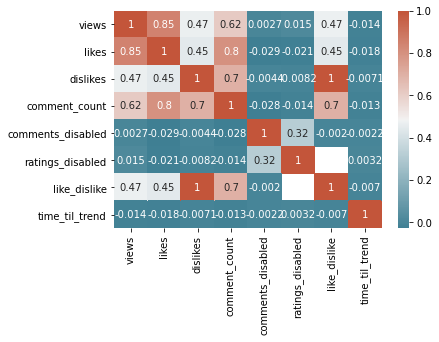

In [11]:
corr = yt_clean.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

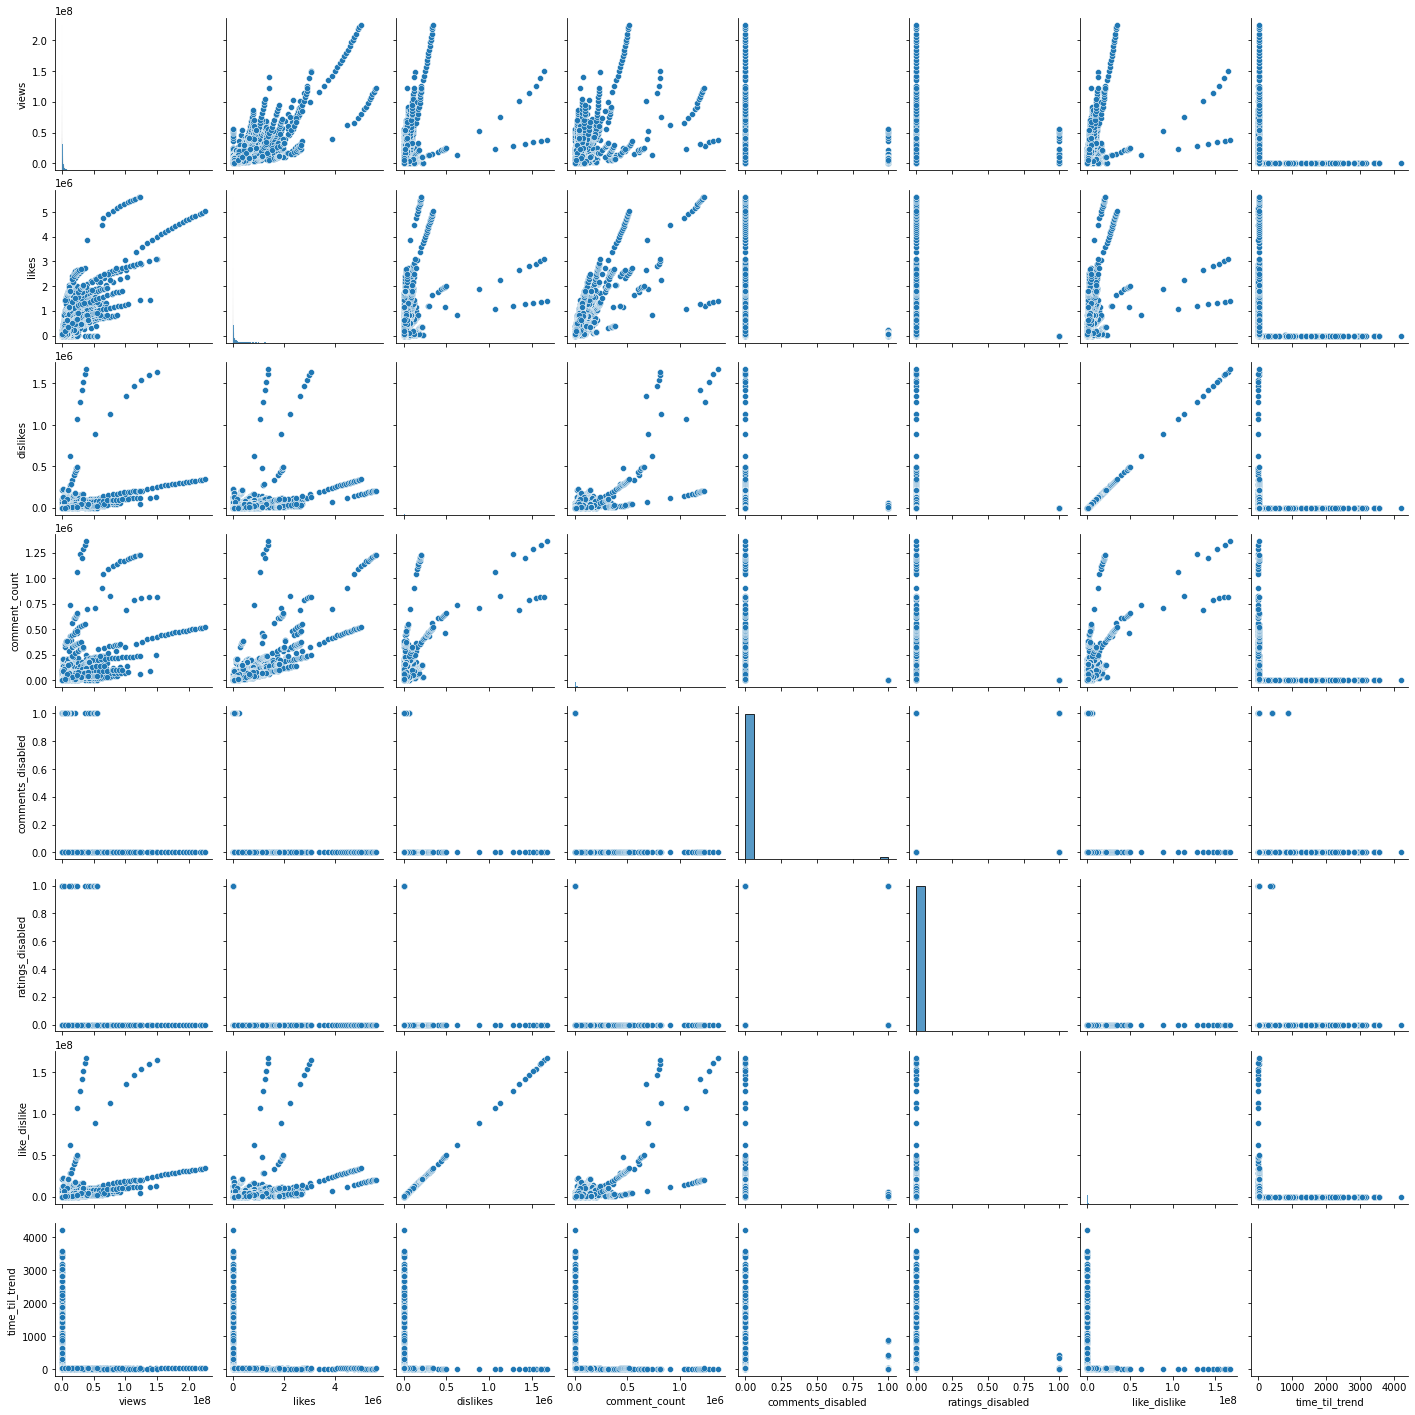

In [12]:
sns.pairplot(yt_clean)

[Text(0, 0, 'People & Blogs'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'Comedy'),
 Text(3, 0, 'Science & Technology'),
 Text(4, 0, 'Film & Animation'),
 Text(5, 0, 'Howto & Sytle'),
 Text(6, 0, 'Sports'),
 Text(7, 0, 'Music'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Education'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Travel & Events'),
 Text(12, 0, 'Gaming'),
 Text(13, 0, 'Nonprofits & Activism'),
 Text(14, 0, 'Shows')]

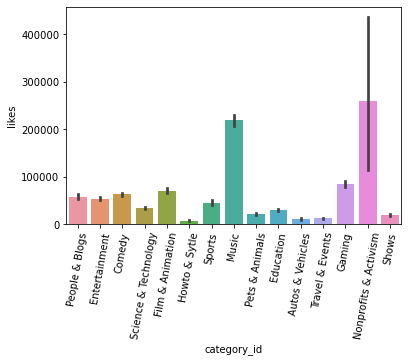

In [24]:
ax = sns.barplot(x="category_id", y="likes", data=yt_clean)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 80)

[Text(0, 0, 'People & Blogs'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'Comedy'),
 Text(3, 0, 'Science & Technology'),
 Text(4, 0, 'Film & Animation'),
 Text(5, 0, 'Howto & Sytle'),
 Text(6, 0, 'Sports'),
 Text(7, 0, 'Music'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Education'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Travel & Events'),
 Text(12, 0, 'Gaming'),
 Text(13, 0, 'Nonprofits & Activism'),
 Text(14, 0, 'Shows')]

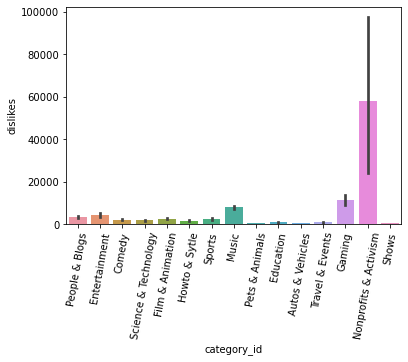

In [25]:
ax = sns.barplot(x="category_id", y="dislikes", data=yt_clean)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

[Text(0, 0, 'People & Blogs'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'Comedy'),
 Text(3, 0, 'Science & Technology'),
 Text(4, 0, 'Film & Animation'),
 Text(5, 0, 'Howto & Sytle'),
 Text(6, 0, 'Sports'),
 Text(7, 0, 'Music'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Education'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Travel & Events'),
 Text(12, 0, 'Gaming'),
 Text(13, 0, 'Nonprofits & Activism'),
 Text(14, 0, 'Shows')]

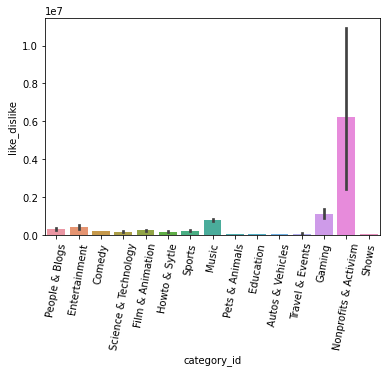

In [35]:
ax = sns.barplot(x="category_id", y="like_dislike", data=yt_clean)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

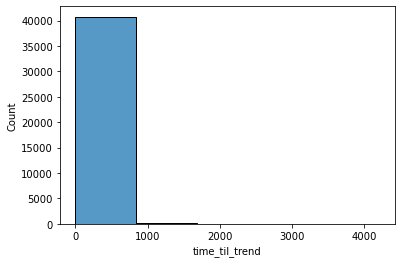

In [31]:
ax = sns.histplot(x="time_til_trend", data=yt_clean, bins=5)

<AxesSubplot:xlabel='time_til_trend', ylabel='dislikes'>

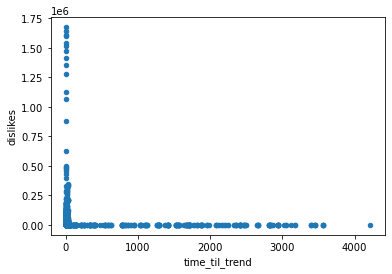

In [34]:
yt_clean.plot(kind='scatter', x='time_til_trend', y='dislikes')

<AxesSubplot:xlabel='comment_count', ylabel='dislikes'>

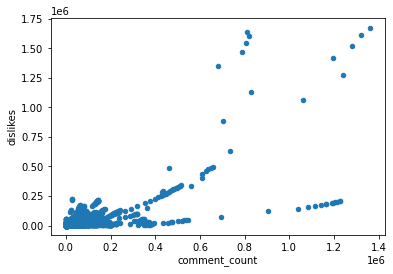

In [17]:
yt_clean.plot(kind='scatter', x='comment_count', y='dislikes')

<AxesSubplot:xlabel='views', ylabel='dislikes'>

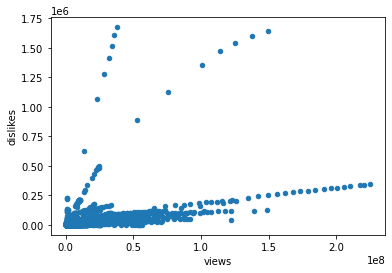

In [18]:
yt_clean.plot(kind='scatter', x='views', y='dislikes')

In [19]:
#Normalize the numerical data
yt_clean['views']=(yt_clean['views']-yt_clean['views'].mean())/yt_clean['views'].std()
yt_clean['likes']=(yt_clean['likes']-yt_clean['likes'].mean())/yt_clean['likes'].std()
yt_clean['comment_count']=(yt_clean['comment_count']-yt_clean['comment_count'].mean())/yt_clean['comment_count'].std()

In [40]:
#Now I am going to pull out all of the values for the category "activism" into another dataframe since this is what I am interested in using for my ML model
yt_active = yt_clean.drop(yt_clean[yt_clean.category_id != 'Nonprofits & Activism'].index)

In [43]:
yt_active.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,like_dislike,time_til_trend
3313,aLSG3178eD4,2017-11-30,Tell Hollywood to stand with immigrants,Define American,Nonprofits & Activism,2017-11-28 13:00:35,1456,0,0,0,1,1,False,NaN,1
3543,aLSG3178eD4,2017-12-01,Tell Hollywood to stand with immigrants,Define American,Nonprofits & Activism,2017-11-28 13:00:35,1873,0,0,0,1,1,False,NaN,2
3776,aLSG3178eD4,2017-12-02,Tell Hollywood to stand with immigrants,Define American,Nonprofits & Activism,2017-11-28 13:00:35,2005,0,0,0,1,1,False,NaN,3
3995,aLSG3178eD4,2017-12-03,Tell Hollywood to stand with immigrants,Define American,Nonprofits & Activism,2017-11-28 13:00:35,2093,0,0,0,1,1,False,NaN,4
4934,0jmDHoPUGKI,2017-12-08,NSC | Face to Face with the Prescription Opioi...,National Safety Council,Nonprofits & Activism,2017-12-05 13:50:17,1967,19,0,3,0,0,False,1.0,2


In [ ]:
#ML Question: Predict how many dislikes a video in the Nonprofits and Activism category will get based on: time_til_trending, comment_count, like/dislike ratio, views